# Negative Fake Companion Technique 
## Using GPU

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import numpy as np
import os

from vip_hci.fits import open_fits

from vip.plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

2023-05-19 15:05:54.959169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 15:05:55.148380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-19 15:05:55.148402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-19 15:05:55.167211: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-19 15:05:55.672041: W tensorflow/stream_executor/platform/de

In [43]:
def plot_residuals(table, adi_cube, fakes_cubes, margin = 30, save=True):
    residuals = adi_cube - fakes_cubes
    for i in range(len(table)):
        pos_x, pos_y = int(table.iloc[i].x), int(table.iloc[i].y)
        print("Detection #" + str(i)+ " x:"+ str(pos_x) +", y:" + str(pos_y))
        plt.subplot(1,3,1)
        plt.imshow(adi_cube[pos_y-30:pos_y+30, pos_x-30:pos_x+30])
        plt.title("Detection")
        plt.subplot(1,3,2)
        plt.imshow(fakes_cubes[pos_y-30:pos_y+30, pos_x-30:pos_x+30])
        plt.title("Model")
        plt.subplot(1,3,3)
        plt.title("Residuals")
        plt.imshow(residuals[pos_y-30:pos_y+30, pos_x-30:pos_x+30])
        plt.figtext(1/2,0.72,"Detection #" + str(i)+ "  x: "+ str(pos_x) +", y: " + str(pos_y), va="center", ha="center", size=10)
        if save:
            plt.savefig("./figures/detection_"+str(i)+".png")
        plt.show()

### Loading data

In [3]:
root = './data/crowded_field/'

cube_route = os.path.join(root, 'center_im_sorted.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth_sorted.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 228, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (228,)


In [4]:
"""from main import shift_and_crop_cube
#selecting the wavelength, shift the image in every frame to one pixel right, one pixel down.
#SPHERE frames are EVEN (1024x1024) but VIP needs ODD frames
if cube[lambda_ch].shape[-1] % 2 == 0:
    print('[WARNING] Cube contains odd frames. Shifting and rescaling...')
    cube = tf.cast(shift_and_crop_cube(cube[lambda_ch]), tf.float32)
else:
    cube = cube[lambda_ch]"""

"from main import shift_and_crop_cube\n#selecting the wavelength, shift the image in every frame to one pixel right, one pixel down.\n#SPHERE frames are EVEN (1024x1024) but VIP needs ODD frames\nif cube[lambda_ch].shape[-1] % 2 == 0:\n    print('[WARNING] Cube contains odd frames. Shifting and rescaling...')\n    cube = tf.cast(shift_and_crop_cube(cube[lambda_ch]), tf.float32)\nelse:\n    cube = cube[lambda_ch]"

In [5]:
from vip_hci.fm import *
from vip_hci.metrics import *
from vip_hci.preproc import *
from vip_hci.var import *

cube = cube[lambda_ch]
#selecting the wavelength, shift the image in every frame to one pixel right, one pixel down.
#SPHERE frames are EVEN (1024x1024) but VIP needs ODD frames
cube_shifted=np.zeros((len(cube),len(cube[0,:,0]),len(cube[0,:,0])))
for i in range (len(cube)):
       cube_shifted[i,:,:]=frame_shift(cube[i,:,:], -1, -1) 
ycube_center,xcube_center = frame_center(cube[0,:,:]) #centro del frame (como la dimension dividido 2)
if len(cube[1,:,1])%2==0:
       ycen=ycube_center-0.5
       xcen=xcube_center-0.5
       newdim=len(cube[1,:,1])-1
       cube_crop=cube_crop_frames(cube_shifted,newdim,xy=[int(ycen),int(xcen)], force=True)    #tagliamo l'immagine'''
else :
       cube_crop=cube
dim1=len(cube_crop)
dim2=len(cube_crop[1,:,1])

New shape: (228, 1023, 1023)


In [6]:
cube = tf.cast(cube_crop, tf.float32)

2023-05-19 15:06:18.819601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ssd_raid/afernandez/miniconda3/envs/tf2/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-19 15:06:18.819740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ssd_raid/afernandez/miniconda3/envs/tf2/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-19 15:06:18.819810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ssd_raid/afernandez/miniconda3/envs/tf2/lib/python3.9/site-packages/cv2/../../lib64:
20

### Normalizing PSF: Creating a template to mimic companions 

The first step consists in creating the fake companion template we will use later to mimic the real one.

We need first to find the real center and standard deviation of the PSF by fitting a gaussian model on pixels, 

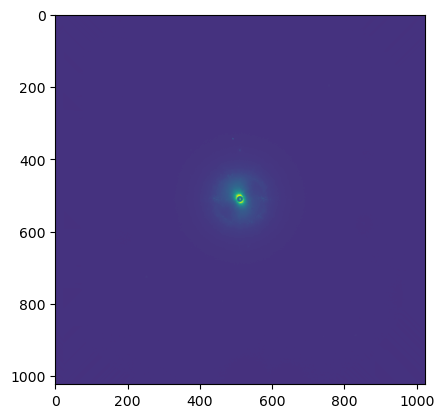

In [7]:
plt.figure(dpi=100)
plt.imshow(cube[0])

In [8]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

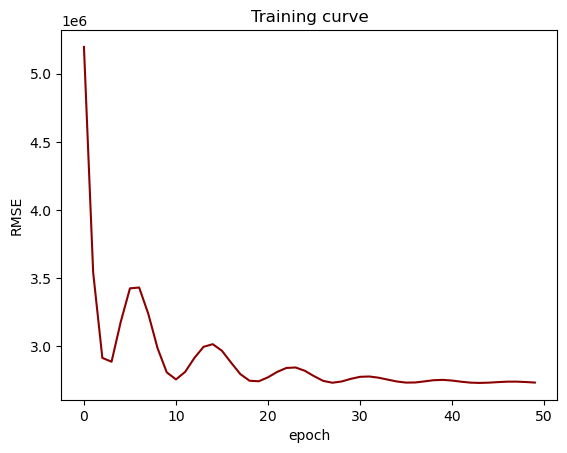

In [9]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Training curve')
plt.show()

Assuming an sphere (i.e., same FWHM along the PSFs) we center all the availables PSFs. This is not used yet, but worth for future work:

In [10]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
centered_psf.shape

TensorShape([2, 64, 64])

Once all the PSFs were aligned we can normalize it to have a 1-FWHM in an aperture equal to FWHM//2

In [11]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

### PCA: Extracting most variable pixels along the time axis from the cube of frames

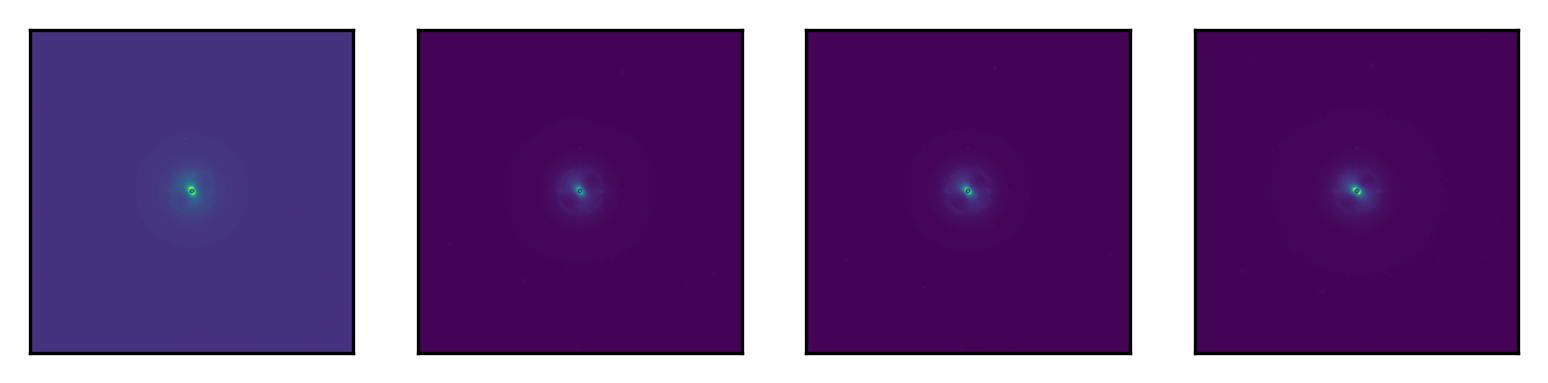

In [12]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
for i, nf in enumerate(range(0, len(cube), 10)):
    try:
        axes[i].imshow(cube[nf])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break

In [13]:
cube.shape

TensorShape([228, 1023, 1023])

In [14]:
%%time
adi_image, res_cube = tfnegfc.apply_adi(cube, 
                                        rot_ang, 
                                        out_size=cube.shape, 
                                        ncomp=1, 
                                        derotate='tf', return_cube=True)

CPU times: user 34.1 s, sys: 21.1 s, total: 55.2 s
Wall time: 11.6 s


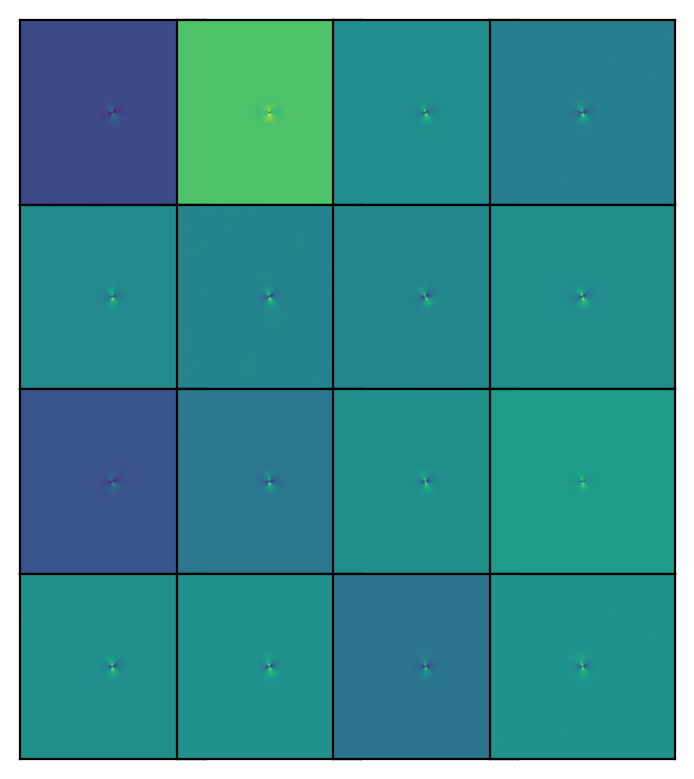

In [15]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, dpi=200,
                        gridspec_kw={'hspace': 0., 'wspace': -0.7},)
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(res_cube[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

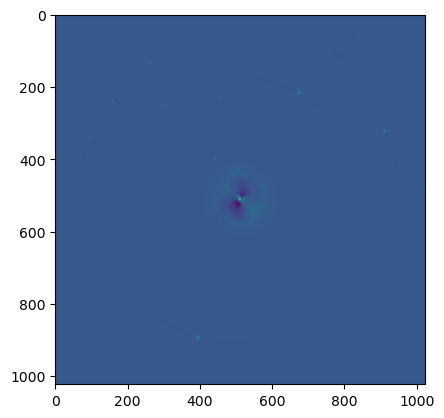

In [16]:
plt.imshow(adi_image)

In [17]:
## mask adi_image
import numpy as np
from skimage.draw import disk
mask = np.ones(cube[0].shape)
radio = 20
rr, cc = disk((adi_image.shape[0]/2, adi_image.shape[1]/2), radio)
mask[rr,cc] = -10**-9
a = tf.multiply(adi_image, mask)

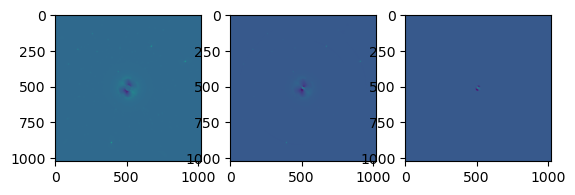

In [18]:
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(adi_image)
plt.subplot(1,3,3)
plt.imshow(adi_image - a)

In [19]:
%%time
table = tfnegfc.get_coords(adi_image.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10, num_peaks=1000)

CPU times: user 1min 7s, sys: 1.78 s, total: 1min 9s
Wall time: 1min 4s


In [20]:
table = tfnegfc.get_coords(a.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10, num_peaks=1000)

In [21]:
table

,x,y,flux,fwhm_mean,snr
0,674.746765,217.551743,342.846576,3.837149,77.791591
1,395.033417,892.936829,353.000876,3.930920,114.584441
2,912.069519,324.059570,359.316614,4.084993,64.017775
3,442.484924,396.347137,146.489070,3.774992,74.634593
4,159.630569,239.594055,153.933123,4.016168,15.955808
...,...,...,...,...,...
252,389.400024,348.501587,1.930804,4.127084,6.384651
253,531.465637,680.034302,0.619626,2.460163,0.274416
254,503.127563,335.550262,2.997696,5.603126,0.875669
255,133.090759,665.060059,1.340919,3.182746,2.370231


In [22]:
#255 -> it should detect 254 with mask (a)

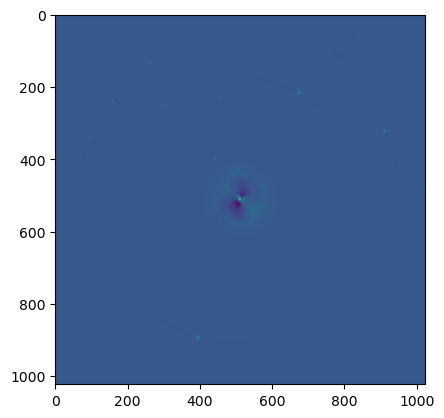

In [23]:
plt.figure()
plt.imshow(adi_image)
plt.show()

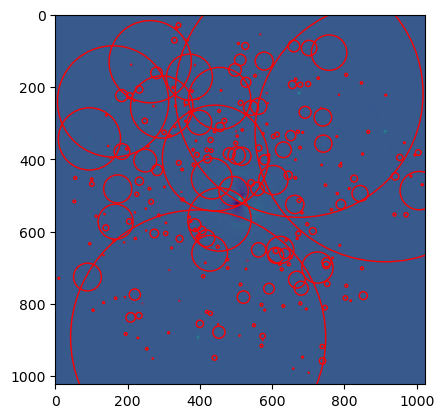

In [24]:
fig, ax = plt.subplots()
ax.imshow(adi_image)
for point in range(len(table)):
    circle1 = plt.Circle((table.iloc[point].x, table.iloc[point].y), table.iloc[point].flux, color="r", fill = False)
    ax.add_artist(circle1)
plt.show()

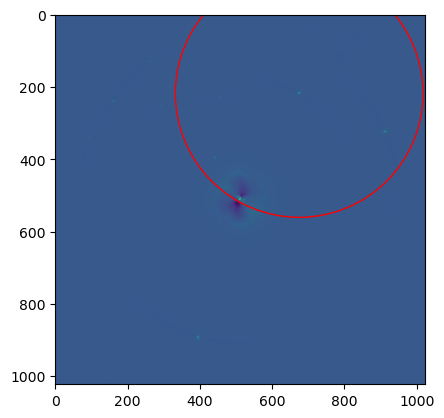

In [25]:
fig, ax = plt.subplots()
ax.imshow(adi_image)
for point in range(len(table[:1])):
    circle1 = plt.Circle((table.iloc[point].x, table.iloc[point].y), table.iloc[point].flux, color="r", fill = False)
    ax.add_artist(circle1)
plt.show()

In [26]:
table[(table.x>=510) & (table.x <=520)]

,x,y,flux,fwhm_mean,snr
42,511.577179,124.679489,15.877890,3.809581,20.931928
61,516.234802,391.585846,25.037964,6.404209,7.714479
90,512.791565,243.588608,6.545964,3.707189,13.649369
147,512.563232,746.289062,3.604527,3.771363,11.652735
154,517.220154,318.602753,3.080968,3.735152,5.371095


In [27]:
table.sort_values(by="flux").tail(20)

,x,y,flux,fwhm_mean,snr
16,172.415451,481.835266,38.905073,3.755014,14.315182
40,603.179871,457.301819,40.368840,6.532472,5.734010
17,493.222351,488.077423,40.609251,4.932156,0.882744
15,725.476868,699.451172,43.214091,3.872044,12.144717
13,166.559128,572.502808,48.465324,3.938584,47.949060
14,757.599487,104.512695,49.026211,4.120410,47.514647
11,427.091797,659.871521,49.330769,3.687481,72.787172
12,1006.996765,486.457977,53.097846,4.219317,89.463804
22,432.865967,453.044189,56.409611,6.118928,9.633374
10,370.970428,172.342514,63.716944,3.770137,112.649692


In [28]:
from astropy.io import fits
image_hdu = fits.ImageHDU(adi_image)
image_hdu.writeto('./figures/adi_cube.fits', overwrite=True)

## CHECKING THE POSTION AND COMPARING WITH FIRSTGUESS

In [46]:
# WITH TABLE POSITIONS AND FLUX
import vip_hci as vip 
i = 10 #detection number
results = vip.fm.negfc_simplex.firstguess(cube.numpy(), 
                                          angs=list(rot_ang),       
                                          psfn=normalized_psf[0].numpy(), 
                                          ncomp=1, 
                                          planets_xy_coord=[(table.iloc[i].x, table.iloc[i].y)],
                                          imlib='opencv',
                                          fwhm=table.iloc[i].fwhm_mean,
                                          simplex=False,
                                          verbose=False,
                                          annulus_width=2*table.iloc[i].fwhm_mean,
                                          aperture_radius=2,
                                          f_range=np.arange(table.iloc[i].flux -10, 1000, 30),
                                         algo_options={
                                             'nproc': 32,
                                             'imlib': 'opencv'
                                         })

In [47]:
r = results[0][0]
theta = results[1][0]
posy = r * np.sin(np.deg2rad(theta)) + ycube_center
posx = r * np.cos(np.deg2rad(theta)) + xcube_center

In [48]:
print("Posiciones con negfc_tf: (X:", str(table.iloc[i].x), "Y:", str(table.iloc[i].y)+")")
print("Posiciones con first_guess: (X:", str(posx), "Y:", str(posy)+")")
print("Diferencia en x:", abs(table.iloc[i].x - posx) , "diferencia en y:", abs(table.iloc[i].y - posy))

Posiciones con negfc_tf: (X: 370.9704284667969 Y: 172.34251403808594)
Posiciones con first_guess: (X: 371.9704284667968 Y: 173.34251403808594)
Diferencia en x: 0.9999999999999432 diferencia en y: 1.0


In [ ]:
##AFTER INJECTING MOONS YOU HAVE TO RECALCULATE THE RESIDUALS IN THE PLACES THAT YOU INJECTED SOMETHING (BECAUSE IT CHANGES DUHHH)

## CALCULATING RESIDUALS

In [55]:
patch = tfnegfc.create_patch(cube[0], normalized_psf[0])
cube_fakes = tf.zeros(cube.shape)
import vip_hci as vip

for i in range(len(table[:3])):
    pos_x, pos_y = table.iloc[i].x, table.iloc[i].y
    results = vip.fm.negfc_simplex.firstguess(cube.numpy(), 
                                          angs=list(rot_ang),       
                                          psfn=normalized_psf[0].numpy(), 
                                          ncomp=1, 
                                          planets_xy_coord=[(pos_x, pos_y)],
                                          imlib='opencv',
                                          fwhm=table.iloc[i].fwhm_mean,
                                          simplex=False,
                                          verbose = False,
                                          annulus_width=2*table.iloc[i].fwhm_mean,
                                          aperture_radius=2,
                                          f_range=np.arange(table.iloc[i].flux -20, 1000, 30),
                                         algo_options={
                                             'nproc': 32,
                                             'imlib': 'opencv'
                                         })
    r = results[0][0]
    theta = results[1][0]
    flux = results[2][0]
    posy = r * np.sin(np.deg2rad(theta)) + ycube_center
    posx = r * np.cos(np.deg2rad(theta)) + xcube_center
    
    fake_zeros = tfnegfc.inject_fake(x=posx, y=posy, flux = +flux, 
                                cube=tf.zeros_like(cube), 
                                patch=patch, 
                                rot_angles=rot_ang)
    cube_fakes += fake_zeros
    """
    cube_negfc = cube_inject_companions(np.zeros_like(cube[0]), normalized_psf[0], rot_ang, flevel=-flux,
                                    rad_dists=[radius_star], n_branches=1,
                                    theta=theta_star)
    """

In [56]:
adi_image_fake_zeros = tfnegfc.apply_adi(cube_fakes, 
                                   rot_ang, 
                                   out_size=(cube.shape),
                                   ncomp=1, 
                                   derotate='tf')

In [57]:
from astropy.io import fits
image_hdu = fits.ImageHDU(adi_image_fake_zeros)
image_hdu.writeto('./figures/fake_adi_cube.fits', overwrite=True)

In [58]:
table["have_moon"] = 0
table.to_csv("detections.csv")

In [59]:
residuals = adi_image - adi_image_fake_zeros
residual_image = fits.ImageHDU(residuals)
residual_image.writeto('./figures/residual_cube.fits', overwrite=True)

Detection #0 x:674, y:217


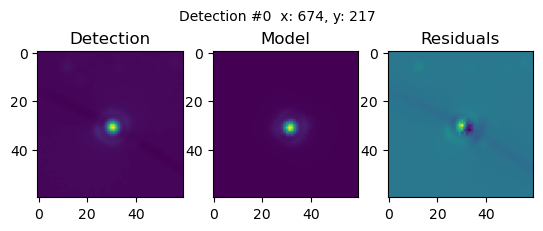

Detection #1 x:395, y:892


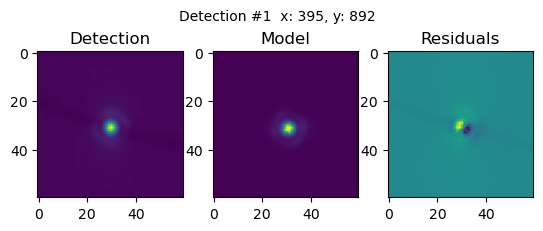

Detection #2 x:912, y:324


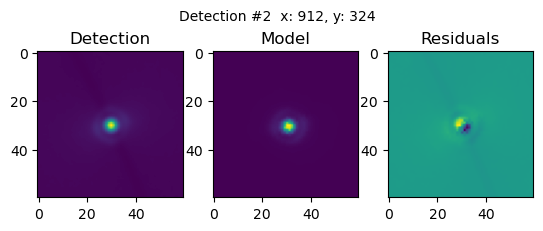

In [60]:
plot_residuals(table[:3], adi_image, adi_image_fake_zeros, margin = 30, save=True)

## INYECTING FAKE MOONS

In [61]:
idxs = ["""ids de las detecciones donde quiero poner lunas"""]

In [ ]:
fake_pos_x = # greater than fwhm less than 5-6-7 times fwhm] 
#que tan cerca del planeta tiene que estar la luna? como afecta el flujo en esto 
fake_pos_y = #[greater than fwhm less than 5-6-7 times fwhm]
flux_fake = ["""between 5 (the flux above fwhm) to 50"""]
for idx in [idxs]:
    fake_zeros = tfnegfc.inject_fake(x=, y=posy, flux = +flux, 
                                cube=tf.zeros_like(cube), 
                                patch=patch, 
                                rot_angles=rot_ang)
    #table.loc[idx, ""]